Notebook adapted from https://www.kaggle.com/code/jhoward/is-it-a-bird-creating-a-model-from-your-own-data

In [1]:
# It's a good idea to ensure you're running the latest version of any libraries you need.
# `!pip install -Uqq <libraries>` upgrades to the latest version of <libraries>
!pip install -Uqq fastai

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-io 0.21.0 requires tensorflow-io-gcs-filesystem==0.21.0, which is not installed.
explainable-ai-sdk 1.3.2 requires xai-image-widget, which is not installed.
tensorflow 2.6.2 requires numpy~=1.19.2, but you have numpy 1.20.3 which is incompatible.
tensorflow 2.6.2 requires six~=1.15.0, but you have six 1.16.0 which is incompatible.
tensorflow 2.6.2 requires typing-extensions~=3.7.4, but you have typing-extensions 3.10.0.2 which is incompatible.
tensorflow 2.6.2 requires wrapt~=1.12.1, but you have wrapt 1.13.3 which is incompatible.
tensorflow-transform 1.5.0 requires absl-py<0.13,>=0.9, but you have absl-py 0.15.0 which is incompatible.
tensorflow-transform 1.5.0 requires numpy<1.20,>=1.16, but you have numpy 1.20.3 which is incompatible.
tensorflow-transform 1.5.0 requires pyarrow<6,>=1, but you have p

But today, we can do exactly that, in just a few minutes, using entirely free resources!

The basic steps we'll take are:

Use DuckDuckGo to search for images of "plane photos"
Use DuckDuckGo to search for images of "superman photos"
Fine-tune a pretrained neural network to recognise these two groups
Try running this model on a picture of a bird and see if it works.


In [2]:
from fastcore.all import *
import time

def search_images(term, max_images=200):
    url='https://duckduckgo.com/'
    res = urlread(url, data={'q': term})
    searchObj = re.search(r'vqd=([\d-]+)\&', res)
    requestUrl = url + 'i.js'
    params = dict(l='us-en', o='json', q=term, vqd=searchObj.group(1), f=',,,', p='1', v7exp='a')
    urls,data = set(),{'next':1}
    while len(urls)<max_images and 'next' in data:
        data = urljson(requestUrl,data=params)
        urls.update(L(data['results']).itemgot('image'))
        requestUrl = url + data['next']
        time.sleep(0.2)
    return L(urls)[:max_images]

In [3]:
urls = search_images('plane photos', max_images=1)
urls[0]

'https://aviationweek.com/sites/default/files/styles/crop_freeform/public/2020-11/xti_trifan_200_2.jpg?itok=SCwKY2_w'

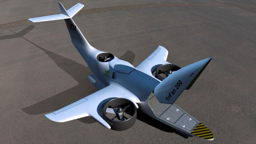

In [4]:
from fastdownload import download_url
dest = 'plane.jpg'
download_url(urls[0], dest, show_progress=False)

from fastai.vision.all import *
im = Image.open(dest)
im.to_thumb(256,256)

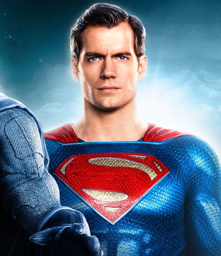

In [5]:
download_url(search_images('superman photos', max_images=1)[0], 'forest.jpg', show_progress=False)
Image.open('forest.jpg').to_thumb(256,256)

In [6]:
searches = 'plane','superman'
path = Path('plane_or_not')

for o in searches:
    dest = (path/o)
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=search_images(f'{o} photo'))
    resize_images(path/o, max_size=400, dest=path/o)

verifying our model

In [7]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

1

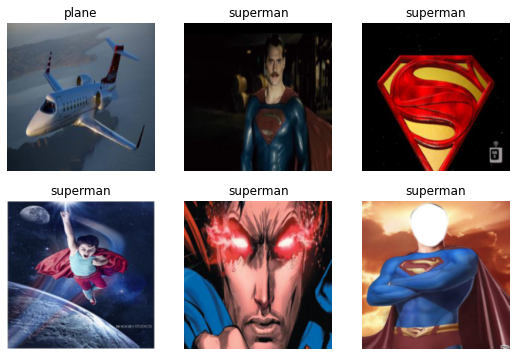

In [8]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
).dataloaders(path)

dls.show_batch(max_n=6)

In [9]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(3)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

epoch,train_loss,valid_loss,error_rate,time
0,0.878825,0.024239,0.000000,00:07


epoch,train_loss,valid_loss,error_rate,time
0,0.080765,0.006396,0.000000,00:02
1,0.051333,0.000658,0.000000,00:01
2,0.035555,0.000415,0.000000,00:01


In [10]:
is_plane,_,probs = learn.predict(PILImage.create('plane.jpg'))
print(f"This is a: {is_plane}.")
print(f"Probability it's a plane: {probs[0]:.4f}")


This is a: plane.
Probability it's a plane: 1.0000
